連線database

In [1]:
import pandas as pd
from sqlalchemy import create_engine
from datetime import datetime, timedelta

# 設置MySQL資料庫連接
db_user = 'root'
db_password = '19970730'
db_host = '127.0.0.1'
db_name = 'sql_stock'

# 創建資料庫連接引擎
engine = create_engine(f'mysql+mysqlconnector://{db_user}:{db_password}@{db_host}/{db_name}')

# 設置日期範圍
#today = datetime(2024, 5, 25)
today = datetime.now().date()
one_year_ago = today - timedelta(days=1000)

# 格式化日期
today_str = today.strftime('%Y%m%d')
one_year_ago_str = one_year_ago.strftime('%Y%m%d')

# 可自由調整select的區間
# today_str = '20240813'
today_str = '20241231'
one_year_ago_str = '20210101'

# SQL 查詢 加權指數
query_daily_tx = f"""
SELECT *
FROM daily_tx
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_daily_updown = f"""
SELECT *
FROM daily_updown
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_tif_investors = f"""
SELECT *
FROM daily_tif_investors
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 加權指數
query_pc_ratio = f"""
SELECT *
FROM daily_pc_ratio
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# SQL 查詢 個股
query_stock = f"""
SELECT *
FROM daily_price
WHERE date >= '{one_year_ago_str}' AND date <= '{today_str}'
"""

# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tif_investors_df_raw = pd.read_sql(query_tif_investors, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
updown_df_raw = pd.read_sql(query_daily_updown, engine)
# 使用 pd.read_sql 來執行查詢並讀取數據到 DataFrame
tx_df_raw = pd.read_sql(query_daily_tx, engine)

pc_ratio_raw = pd.read_sql(query_pc_ratio, engine)

stock_df_raw = pd.read_sql(query_stock, engine)
stock_df_raw['Date'] = pd.to_datetime(stock_df_raw['Date'])

In [4]:
# 每天成交金額
stock_date_list = stock_df_raw[(stock_df_raw['Date']>='2024-12-10' ) & (stock_df_raw['Date']<='2024-12-19' ) & (stock_df_raw['證券代號'] == '2330' ) ]['Date']
collected_data = pd.DataFrame(columns=['證券代號','證券名稱', '收盤價', 'Date'])

for day in stock_date_list:
        stock_df_today = stock_df_raw[(stock_df_raw['Date'] == day)].sort_values(by='成交金額',ascending=False).head(30)

In [5]:
import pandas as pd

# 篩選指定日期範圍的資料
stock_date_list = stock_df_raw[
    (stock_df_raw['Date'] >= '2024-11-01') & 
    (stock_df_raw['Date'] <= '2024-12-20') & 
    (stock_df_raw['證券代號'] == '2330')
]['Date'].unique()

# 初始化 DataFrame 紀錄每日變動
change_log = pd.DataFrame(columns=['Date', '新增股票', '被踢出股票', '濾網股票'])

# 初始化前一天排行榜的股票列表
previous_top_stocks = set()

for idx, day in enumerate(stock_date_list):
    # 當日排行榜股票（Top 30，依成交金額排序）
    stock_df_today = stock_df_raw[stock_df_raw['Date'] == day].sort_values(by='成交金額', ascending=False).head(20)
    # stock_df_today_filter = stock_df_today[(stock_df_today['20RS_rank'] > 90) ]
    current_top_stocks = set(stock_df_today['證券名稱'].values)

    # 新增濾網
    stock_df_today_filter = stock_df_today[(stock_df_today['20RS_rank'] > 90) & (stock_df_today['收盤價'] > stock_df_today['開盤價'])  ]

    if idx > 0:  # 從第二天開始記錄變化
        # 計算進入和被踢出的股票
        new_entries = current_top_stocks - previous_top_stocks  # 當天新增進入的股票
        removed_entries = previous_top_stocks - current_top_stocks  # 當天被踢出的股票

        # 新增條件的股票
        filter_stock = set(stock_df_today_filter['證券名稱'].values)


        # 將變化紀錄到 DataFrame
        change_log = pd.concat([
            change_log,
            pd.DataFrame({
                'Date': [day],
                '新增股票': [', '.join(new_entries)],
                '被踢出股票': [', '.join(removed_entries)],
                '濾網股票' : [', '.join(new_entries & filter_stock)],
            })
        ], ignore_index=True)
    
    # 更新前一天的排行榜
    previous_top_stocks = current_top_stocks

# 查看結果
change_log.tail(5)

C:\Users\USER\AppData\Local\Temp\ipykernel_18268\3550276947.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  change_log = pd.concat([


,Date,新增股票,被踢出股票,濾網股票
30,2024-12-16,"信驊, 京元電子, 緯創, 奇鋐, 廣達","零壹, 聯亞, 聯電, 上詮, 華星光",
31,2024-12-17,"佳能, 聯電, 旺矽, 智原, 祥碩, 羅昇, 所羅門","信驊, 順達, 京元電子, 智邦, 緯創, 台達電, 奇鋐","佳能, 旺矽, 智原, 羅昇, 祥碩, 所羅門"
32,2024-12-18,"華通, 順達, 上銀, 貿聯-KY, 長榮, 奇鋐, 全球傳動, 台灣精銳","佳能, 金像電, 聯電, 旺矽, 智原, 祥碩, 羅昇, 陽明","華通, 上銀, 台灣精銳"
33,2024-12-19,"鈞興-KY, 佳能, 智邦, 新盛力, 華星光, 陽明","華通, 順達, 奇鋐, 全球傳動, 台光電, 台灣精銳","智邦, 佳能, 鈞興-KY, 新盛力"
34,2024-12-20,"立碁, 眾達-KY, 環宇-KY, 啟碁, 奇鋐, 台光電","鈞興-KY, 上銀, 貿聯-KY, 新盛力, 華星光, 神達","環宇-KY, 啟碁"


In [30]:
import pandas as pd

# 定義分頁名稱
sheet_names = ['2023Q1', '2023Q2', '2023Q3', '2023Q4','2024Q1', '2024Q2', '2024Q3', '2024Q4']

# 初始化一個空列表來存放各分頁的 DataFrame
dataframes = []

# 遍歷分頁名稱，讀取每個分頁並添加到列表中
for sheet in sheet_names:
    df = pd.read_excel('c:/Users/USER/OneDrive/桌面/佛爾德/p1_excel.xlsx', sheet_name=sheet)
    # df['Quarter'] = sheet  # 添加一列以標記分頁來源
    dataframes.append(df)

# 將所有 DataFrame 合併成一個
final_df = pd.concat(dataframes, ignore_index=True)

# 查看合併結果
final_df.rename(columns={'成交日期': 'Date','股票名稱': '證券名稱','成交股數': '賣出股數'}, inplace=True)

final_df.iloc[22, final_df.columns.get_loc('Date')] = '2023/03/22'
final_df['Date'] = pd.to_datetime(final_df['Date'])
# final_df['Date'] = pd.to_datetime(final_df['Date'], format='%Y/%m/%d')
# final_df['Date'] = final_df['Date'].dt.strftime('%Y-%m-%d')

final_df = final_df[(final_df['賣出股數'] > 1000) & (final_df['交易類別'] != '融券')]
merged_df = pd.merge(final_df, stock_df_raw, on=['Date', '證券名稱'], how='inner')

In [45]:
final_df

,Date,證券名稱,交易類別,賣出股數,成交價格,報酬率(％)
0,2023-03-30,富邦越南,普通,21000,11.24,-33.48
1,2023-03-30,富邦越南,普通,20000,11.24,-33.48
2,2023-03-30,富邦越南,普通,20000,11.24,-33.48
3,2023-03-30,台肥,普通,10000,56.40,-16.39
4,2023-03-30,瓦城,普通,2000,248.50,7.63
...,...,...,...,...,...,...
288,2024-12-10,融程電,普通,8000,156.50,6.06
289,2024-12-10,融程電,普通,2000,156.00,5.72
290,2024-12-10,永信,普通,30000,55.70,2.13
291,2024-12-10,東洋,普通,20000,74.30,-1.05


In [31]:
print(merged_df[merged_df['報酬率(％)'] > 0]['報酬率(％)'].mean())
print(merged_df[merged_df['報酬率(％)'] < 0]['報酬率(％)'].mean())

print(len(merged_df[merged_df['報酬率(％)'] > 0]['報酬率(％)']) / len(merged_df['報酬率(％)'])  )

print(merged_df['60RS_rank'].mean())
print(merged_df['240RS_rank'].mean())

23.139754098360655
-11.17031746031746
0.6594594594594595
54.407261908108104
72.47300247027027


In [83]:
# merged_df[merged_df['成交價格'] < merged_df['5MA']]

# 按 Date 和 證券名稱 分组，计算平均成交價格
grouped_df = (
    final_df
    .groupby(['Date', '證券名稱'])
    .agg(平均成交價格=('成交價格', 'mean') , 平均報酬率=('報酬率(％)', 'mean'), 股數=('賣出股數', 'sum'))
    .reset_index()
)


merged_df_group = pd.merge(grouped_df, stock_df_raw, on=['Date', '證券名稱'], how='inner')

merged_df_group1 = merged_df_group[merged_df_group['平均報酬率'] > 0]
merged_df_group2 = merged_df_group[merged_df_group['平均報酬率'] <= 0]


merged_df_group['股數'] = merged_df_group['股數']/1000
# 新光金是事件交易 砍掉
merged_df_group = merged_df_group[merged_df_group['股數'] < 100]

In [96]:
merged_df_group[merged_df_group['股數'] < 10]['平均報酬率'].mean()

17.127142857142857

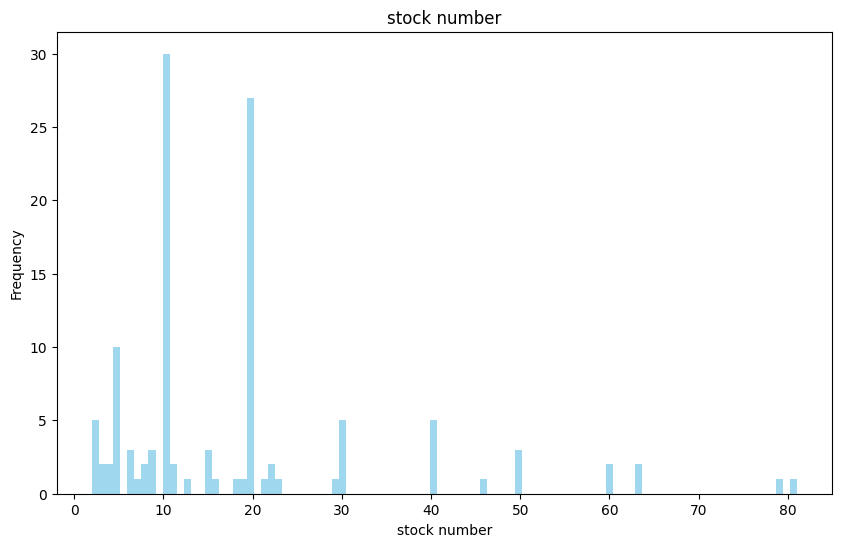

In [ ]:

# 賣出股數
import matplotlib.pyplot as plt

# 假设 merged_df 已包含 '20RS_rank' 列
merged_df_group['股數'].plot.hist(
    bins=100,  # 直方图的柱子数量
    figsize=(10, 6),  # 图表大小
    color='skyblue',  # 颜色
    alpha=0.8,  # 透明度
    title= 'stock number'  # 图表标题
)

# 添加轴标签
plt.xlabel('stock number')
plt.ylabel('Frequency')

# 显示图表
plt.show()

In [117]:
print(round(merged_df_group1['平均報酬率'].mean(),2))
print(round(merged_df_group2['平均報酬率'].mean(),2))
print(round(len(merged_df_group1) / len(merged_df_group['平均報酬率']),2))

22.01
-10.74
0.66


賺賠比 2 : 1 勝率 6成6

In [104]:
print(round(len(merged_df_group1[merged_df_group1['平均成交價格'] > merged_df_group1['5MA']]) / len(merged_df_group1),2 ))
print(round(len(merged_df_group1[merged_df_group1['平均成交價格'] > merged_df_group1['10MA']]) / len(merged_df_group1),2 ))
print(round(len(merged_df_group1[merged_df_group1['平均成交價格'] > merged_df_group1['20MA']]) / len(merged_df_group1),2 ))
print(round(len(merged_df_group1[merged_df_group1['平均成交價格'] > merged_df_group1['60MA']]) / len(merged_df_group1),2 ))
print(round(len(merged_df_group1[merged_df_group1['平均成交價格'] > merged_df_group1['240MA']]) / len(merged_df_group1),2 ))

print('=========================')

print(round(len(merged_df_group2[merged_df_group2['平均成交價格'] > merged_df_group2['5MA']]) / len(merged_df_group2),2 ))
print(round(len(merged_df_group2[merged_df_group2['平均成交價格'] > merged_df_group2['10MA']]) / len(merged_df_group2),2 ))
print(round(len(merged_df_group2[merged_df_group2['平均成交價格'] > merged_df_group2['20MA']]) / len(merged_df_group2) ,2 ))
print(round(len(merged_df_group2[merged_df_group2['平均成交價格'] > merged_df_group2['60MA']]) / len(merged_df_group2) ,2 ))
print(round(len(merged_df_group2[merged_df_group2['平均成交價格'] > merged_df_group2['240MA']]) / len(merged_df_group2) ,2 ))

0.34
0.38
0.51
0.81
0.96
0.24
0.21
0.19
0.43
0.6


停利點 幾乎都在 均線之上 但停損點幾乎都在均線之下 可以想像是 停利不會因為要破線才走 但停損一定是破線就走囉?

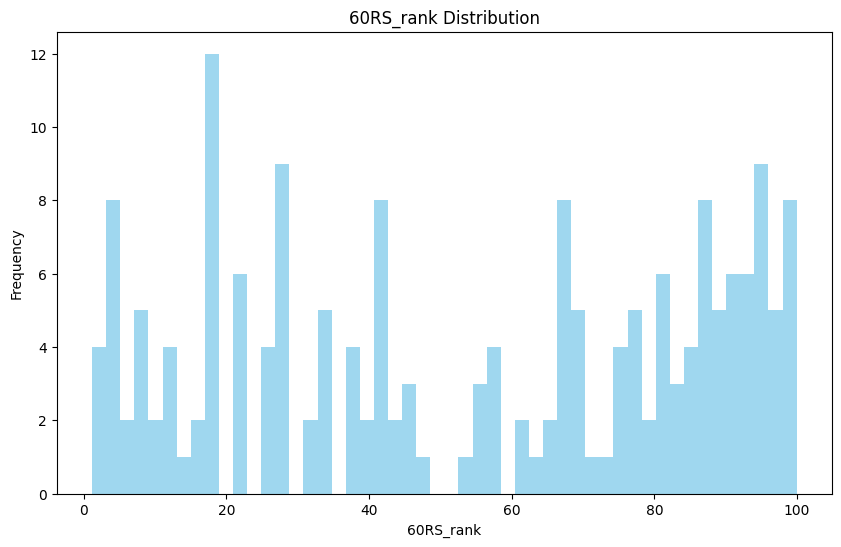

In [113]:
import matplotlib.pyplot as plt

title= '60RS_rank'
# 假设 merged_df 已包含 '20RS_rank' 列
merged_df[title].plot.hist(
    bins=50,  # 直方图的柱子数量
    figsize=(10, 6),  # 图表大小
    color='skyblue',  # 颜色
    alpha=0.8,  # 透明度
    title= title + ' Distribution'  # 图表标题
)

# 添加轴标签
plt.xlabel(title)
plt.ylabel('Frequency')

# 显示图表
plt.show()

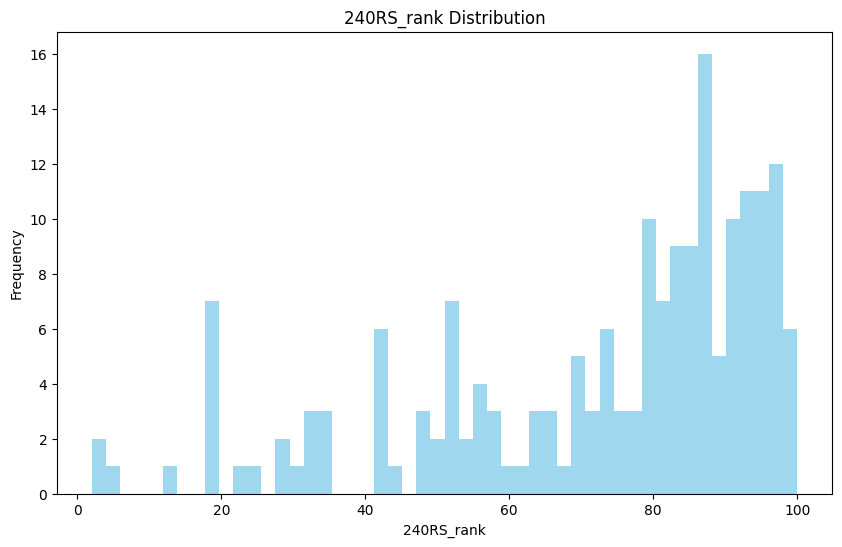

In [58]:
import matplotlib.pyplot as plt

title= '240RS_rank'
# 假设 merged_df 已包含 '20RS_rank' 列
merged_df[title].plot.hist(
    bins=50,  # 直方图的柱子数量
    figsize=(10, 6),  # 图表大小
    color='skyblue',  # 颜色
    alpha=0.8,  # 透明度
    title= title + ' Distribution'  # 图表标题
)

# 添加轴标签
plt.xlabel(title)
plt.ylabel('Frequency')

# 显示图表
plt.show()
